# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.079286,True,3.821434
1,-0.997988,False,-1.909692
2,-1.052842,False,-4.261521
3,-0.751767,False,-2.156837
4,-0.802909,False,-2.135282
...,...,...,...
995,-2.096780,False,-5.375187
996,-0.934955,True,2.484935
997,0.295682,True,4.772712
998,-0.035742,True,6.235342


<AxesSubplot:xlabel='v0'>

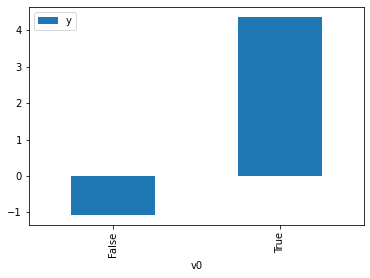

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

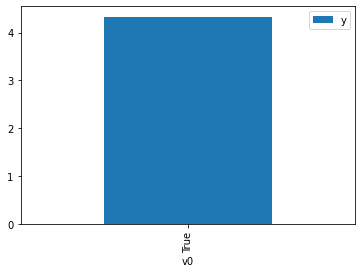

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.722995,False,-1.534368,0.840766,1.189392
1,-1.065476,False,-0.485021,0.921337,1.085379
2,-1.644891,False,-0.579511,0.978301,1.022180
3,-0.681593,False,0.184384,0.827444,1.208540
4,0.541094,False,0.646150,0.218108,4.584886
...,...,...,...,...,...
995,0.690226,False,0.076791,0.164702,6.071585
996,0.355560,False,0.425776,0.300458,3.328250
997,-1.893135,False,-2.808480,0.987703,1.012450
998,-0.843561,False,-2.083766,0.874836,1.143072


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.114115,True,7.265172,0.438441,2.280809
1,-1.294819,True,2.108284,0.047690,20.968848
2,-0.079459,True,3.628755,0.458378,2.181604
3,0.370500,True,3.707393,0.706796,1.414836
4,-0.475199,True,3.211706,0.252092,3.966804
...,...,...,...,...,...
995,-0.532449,True,2.823376,0.227819,4.389445
996,-0.967405,True,1.932767,0.096869,10.323225
997,-0.934955,True,2.484935,0.103677,9.645334
998,-0.165721,True,4.663051,0.409134,2.444185


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.939
Model:                            OLS   Adj. R-squared (uncentered):              0.939
Method:                 Least Squares   F-statistic:                              7717.
Date:                Wed, 03 Aug 2022   Prob (F-statistic):                        0.00
Time:                        08:18:30   Log-Likelihood:                         -1427.5
No. Observations:                1000   AIC:                                      2859.
Df Residuals:                     998   BIC:                                      2869.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0230      0.029     68.689      0.000       1.965       2.081
x2             4.9924      0.056     89.908      0.000       4.883       5.101
==============================================================================
Omnibus:                        0.859   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.651   Jarque-Bera (JB):                0.856
Skew:                          -0.071   Prob(JB):                        0.652
Kurtosis:                       2.987   Cond. No.                         1.94
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""